# Example Filtering ICON Data on Native Grid
_Aaron Wienkers, 2024_

### Installing ICON-specific version:  `implicit_filter_ICON`

`pip install git+https://github.com/wienkers/implicit_filter_ICON.git`

Other necessary dependencies (if they don't install automatically): \
`pip install cupy pyamgx`

### Modifications from main branch of `implicit_filter`:
1. Built-in support for the `ICON` grid
    - Uses new JAX routines for vertex- and cell-centred transformations
2. Support for spatially-varying length-scale filters, e.g. if $\Delta \propto \mathcal{L}_\mathrm{Ro}$
3. Implements arbitrary boundary conditions in a conservative fashion
    - This is necessary when filtering deeper layers in the ocean when the sea-floor boundaries change
    - These BCs ensure no artificial mass/energy/tracer leakage through the boundaries, and which otherwise produces halos in the high-pass fields
4. Adds MPI support for multi-GPU machines
    - Batches GPU computations (in time & wavenumber space) to avoid running out of memory
5. Improves convergence properties of 2nd Order filter using a tuned Algebriac Multigrid Solver (AMGX)
    - CG Convergence of the 2nd Order filter with the original block-wise structure was either slow or (for larger filter length-scales $\sim 100$ km) divergent
    - AMGX Solver Converges faster on 2nd Order Filter compared to `cupy` CG implementation of 1st Order Filter, even up to $\Delta \approx 10^4$ km
    - N.B.: Using 2nd Order filter is necessary for many higher-order filtered statistics and when a sharp(er) filter cutoff is required


N.B.: This example notebook will only consider a 2nd Order variable-length $\mathcal{L}_\mathrm{Ro}$ filter with AMGX. 

In [19]:
import xarray as xr

import intake
import dask
import subprocess
import pyicon as pyic
import matplotlib.pylab as plt
import matplotlib.cm as cm

from dask.distributed import Client, LocalCluster

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import os
import re
import warnings

try:
    from implicit_filter import AMGXFilter
except ImportError:
    warnings.warn("GPU Needed to run this notebook with AMGX Filter")


# Setup

## Parameters & Options

In [2]:
## Example Data Subset Selection
t_slice = slice('2024-01-01', '2024-02-01')

## Filter Options
make_filter         = False # Should we re-compute (and over-write) the filter (N.B.: This takes ~6 minutes per filter...) ?
filter_order        = 2     
L_Ro_max            = 20.0  # Maximum Rossby Radius for the variable filter (km)
L_Ro_min            = 5.0   # Minimum... (km)
filter_lengthscale  = 20.0  # Filter length-scale, in units of L_Ro

In [3]:
## Directories
scratch_dir          = Path('/scratch') / getuser()[0] / getuser()

filter_dir           = scratch_dir / 'filters'
zarr_fpath_tgrid     = scratch_dir / 'grid_files'  / 'fpath_tgrid.zarr'  # For faster unstructured plotting
cluster_scratch      = scratch_dir / 'clients'

## Start Local GPU Cluster

In [ ]:
dask_tmp_dir = TemporaryDirectory(dir=cluster_scratch)
dask.config.set(temporary_directory=dask_tmp_dir.name)
dask.config.set({'array.slicing.split_large_chunks': False})

cluster = LocalCluster(n_workers=8, threads_per_worker=4, memory_limit="60GiB")
client = Client(cluster)
#client

remote_node = subprocess.run(['hostname'], capture_output=True, text=True).stdout.strip().split('.')[0]
port = re.search(r':(\d+)/', client.dashboard_link).group(1)
print(f"Forward with Port = {remote_node}:{port}")

client.dashboard_link

## Open & Prepare Data

In [5]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
version = 'v20231106'
model = 'icon-esm-er'
gridspec = 'native'

In [ ]:
## Ocean EERIE Catalogue
dat = cat['dkrz.disk.model-output'][model][expid][version]['ocean'][gridspec]
ds_ocn = dat['2d_daily_mean'](chunks={}).to_dask().isel(depth=0).isel(lev=0).sel(time=t_slice)

In [7]:
## ICON Grid Properties
grid2d = dat['2d_grid'](chunks={}).to_dask().rename({'cell':'ncells'})
resolution = 5.0 # km
depth_ind = 0

## Compute / Load T-Grid

In [8]:
if not os.path.exists(str(zarr_fpath_tgrid)):
    from pyicon.pyicon_tb import identify_grid
    from pyicon.pyicon_params import params
    path_grid = params['path_grid']
    Dgrid = identify_grid(grid2d, path_grid, uuidOfHGrid=grid2d.attrs['uuidOfHGrid'])
    fpath_tgrid = Dgrid['fpath_grid']
    ds_tg = xr.open_dataset(fpath_tgrid, chunks={})
    ds_tg.to_zarr(zarr_fpath_tgrid, mode='w')
    

## Compute / Load & Define Filter

Construct a filter here defined by:
- $\Delta \propto \mathcal{L}_\mathrm{Ro}$, with a pre-specified minimum and maximum $\mathcal{L}_\mathrm{Ro}$
- Neumann BCs at edge of surface land-sea mask
- Both scalar & full vector-metric filters

In [9]:
# Variable L_Ro Filter
if make_filter or not os.path.exists(str(filter_dir / "filter_cache_2D_LRo_full_ocean.npz")):
    L_Ro = xr.open_dataarray('/home/b/b382615/data/RossbyRadius_ICON_native.nc')  # 
    mask = grid2d.cell_sea_land_mask
    full_ocean_mask = xr.where(mask < 0.0, 1.0, 0.0)  # 1.0 for entire ocean  
    
    filter = AMGXFilter()
    filter.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=False, L_Ro=L_Ro, L_Ro_min = L_Ro_min, L_Ro_max = L_Ro_max)
    filter.save_to_file(filter_dir / "filter_cache_2D_LRo_full_ocean")
    
    filter_vec = AMGXFilter()
    filter_vec.prepare_ICON_filter(grid2d, ocean_mask=full_ocean_mask, full=True, L_Ro=L_Ro, L_Ro_min = L_Ro_min, L_Ro_max = L_Ro_max)
    filter_vec.save_to_file(filter_dir / "filter_cache_full_2D_LRo_full_ocean")

else:
    filter = AMGXFilter.load_from_file(filter_dir / "filter_cache_2D_LRo_full_ocean.npz")
    filter_vec = AMGXFilter.load_from_file(filter_dir / "filter_cache_full_2D_LRo_full_ocean.npz")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Filter Data

### Scalar Data

In [ ]:
## Low-pass filter
#    Takes ~10 minutes to filter 38x365 slices  (4 GPUs)
sst_full = ds_ocn.to
sst_low = filter.filter_ICON(filter_order, filter_lengthscale, sst_full)

## High-pass filter
sst_high = (sst_full - sst_low)

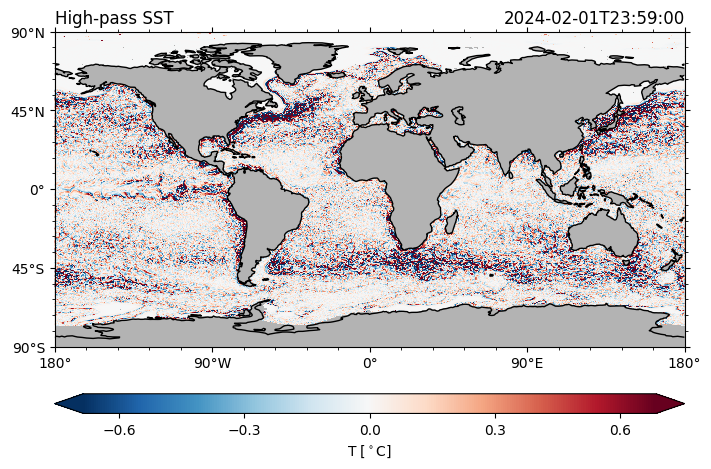

In [31]:
sst_high.isel(time=-1).pyic.plot(clim='robustsym', title_left="High-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

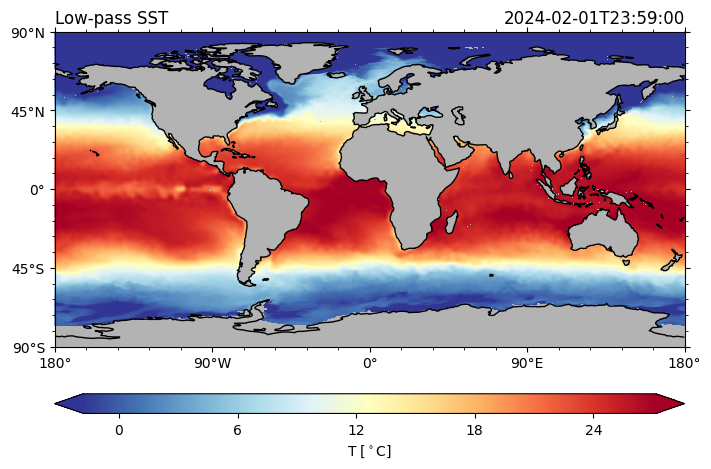

In [32]:
sst_low.isel(time=-1).pyic.plot(clim='robust', title_left="Low-pass SST", cbar_str=f"T [$^\circ$C]", fpath_tgrid=zarr_fpath_tgrid)

### Vector Data

In [ ]:
## Low-pass filter
u_full = ds_ocn.u
v_full = ds_ocn.v
u_low, v_low = filter_vec.filter_ICON(filter_order, filter_lengthscale, u_full, v_full)

## High-pass filter
u_high = (u_full - u_low)
v_high = (v_full - v_low)

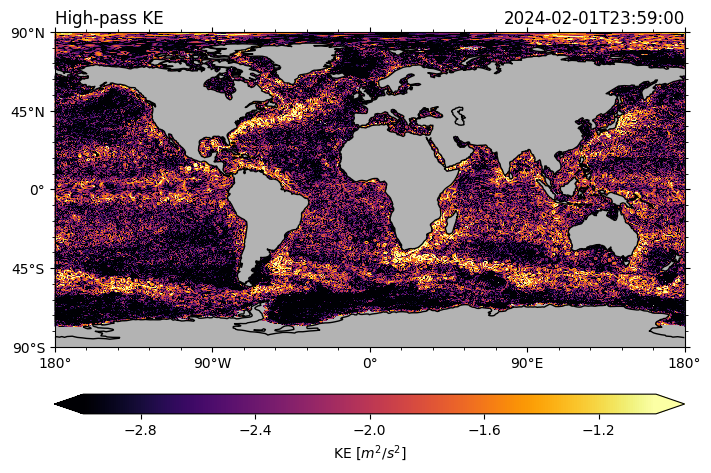

In [29]:
(0.5*(u_high**2 + v_high**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3.0,-1.0), title_left="High-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)

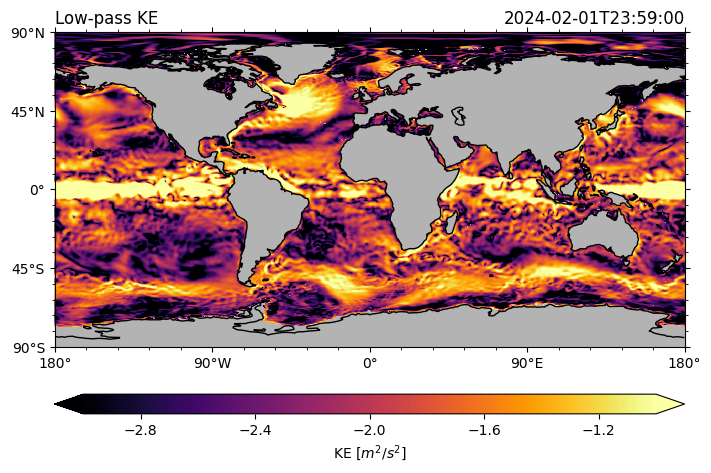

In [30]:
(0.5*(u_low**2 + v_low**2)).isel(time=-1).pyic.plot(cmap=cm.inferno, clim=(-3,-1), title_left="Low-pass KE", logplot=True, cbar_str=f"KE [$m^2/s^2$]", fpath_tgrid=zarr_fpath_tgrid)